<a href="https://colab.research.google.com/github/Eduard953/Image_Processing_SS20/blob/master/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Processing SS 20 - Assignment - 03

### Deadline is 13.5.2020 at 11:55am

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.
Please strip the output from the cells, either select `Cell` -> `All Output` -> `Clear` or use the `nb_strip_output.py` script / git hook.

In [0]:
# display the plots inside the notebook
%matplotlib inline

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import ssl
from urllib.request import urlopen
from skimage.data import astronaut
from skimage.color import rgb2gray, rgb2hsv, hsv2rgb
import math

pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

In [0]:
img = astronaut() / 255.
img_hsv = rgb2hsv(img)
img_gray = rgb2gray(img)

# Exercise 1 - Implement a Histogram Mapping - 1 Points

In [0]:
def norm_cdf(arr):
    return arr / arr[-1]

In [0]:
def gamma_mapping(gamma):
    """
    Returns a 1-dimensional numpy array. The value of the array at the n-position 
    is `(n/len(array))**gamma`.
    """
    return norm_cdf(np.linspace(0, 1, 255)**gamma)


def sigmoid_mapping(gain = 10, cutoff = 0.5):
    """
    Returns a 1-dimensional numpy array. The value of the array at the n-position 
    is  `1/(1 + exp*(gain*(cutoff - (n/len(array)))))`.
    """
    return 1/(1 + np.exp(gain*(-(np.linspace(0,1,255)) +cutoff)))

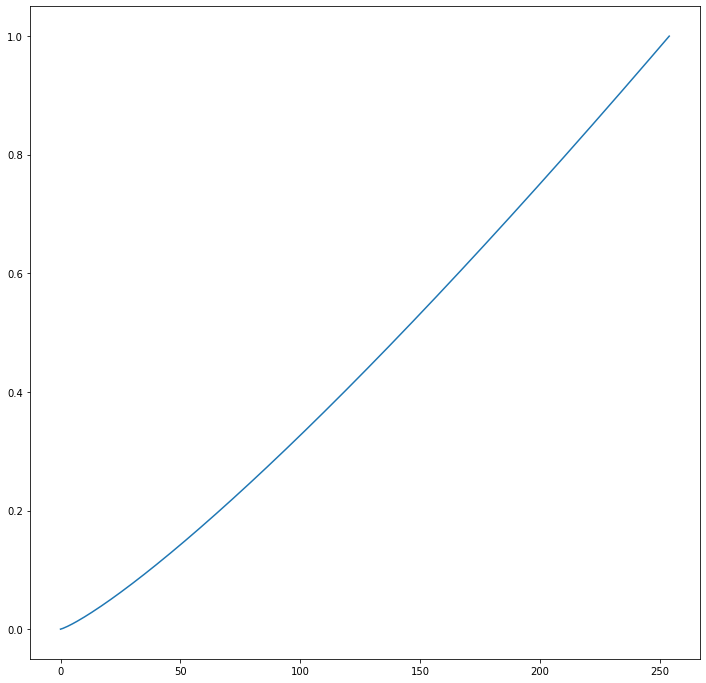

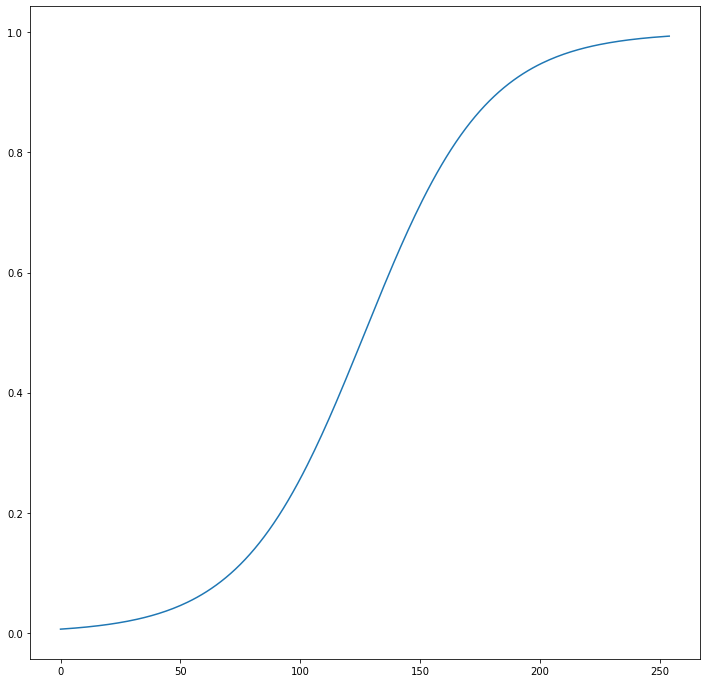

In [6]:
plt.plot(gamma_mapping(1.2))
plt.show()

plt.plot(sigmoid_mapping())
plt.show()

# Exercise 2 - Histogram Transformation - 2 Points

In [0]:
def apply_pixel_mapping(image, mapping):
    """Returns the image transformed according to the mapping array. 
       `mapping` is a one dimensional numpy array. `image` can be 2 or 3-dimensional.
       The values of the image are in range 0 to 1. 
       If the mapping has for example 255 items, then all pixel with a value from 0 to 1/255 are assigned to 
       the value mapping[0]. If the pixel is between n / 255 and (n+1) / 255 then the value in the output image should 
       be mapping[n]
    """
    if len(image.shape) == 2:
      out = np.copy(image)
      idx = (np.floor(out * (len(mapping)-1))).astype(int)
      out = mapping.take(idx)
      
    
    else:
      out = np.copy(image)
      idx = (np.floor(out * (len(mapping)-1))).astype(int)
      out[:,:,0] = mapping.take(idx[:,:,0])
      out[:,:,1] = mapping.take(idx[:,:,1])
      out[:,:,2] = mapping.take(idx[:,:,2])
    return out

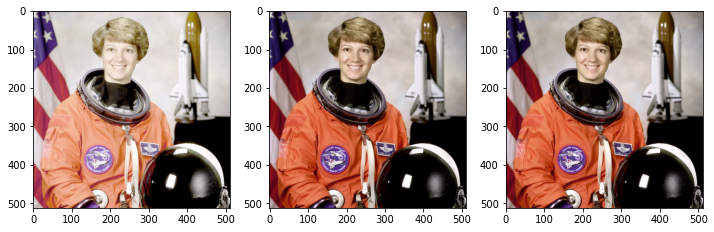

In [8]:
# you can test your `apply_pixel_mapping` function
# The first image should look lighter. The second and third should be the same image.
img_gamma05 = apply_pixel_mapping(img, gamma_mapping(0.5))
plt.subplot(131)
plt.imshow(img_gamma05, cmap='gray')
plt.subplot(132)
plt.imshow(apply_pixel_mapping(img_gamma05, gamma_mapping(2)), cmap='gray')
plt.subplot(133)
plt.imshow(img, cmap='gray')
plt.show()

# Exercise 3 - Implement Histogram Equalisation - 2 Points

Equalize the image given image so that the histogram is mostly uniform distributed.
You can use `np.histogram` and `np.cumsum`. Checkout the documentation of `np.histogram`, it might have useful optional arguments.

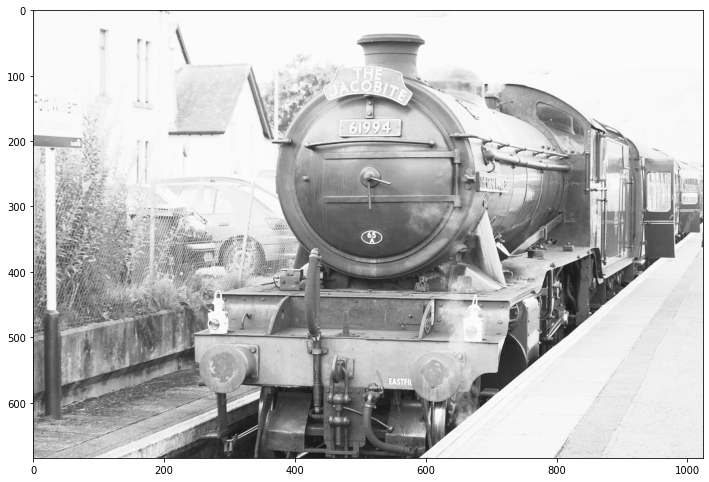

In [9]:
# bypass certficate check here since there are sometimes problems with urllib
ssl._create_default_https_context = ssl._create_unverified_context
f = urlopen("https://dl.dropboxusercontent.com/s/ahj4nff6ba8b8sg/lok.jpg?dl=0")
train = rgb2gray(plt.imread(f, format='jpeg'))
plt.imshow(train, cmap='gray')
plt.show()

In [0]:
hist = np.histogram(train,bins=255,range=(0.0, 1.0), density=True) # get the histogram of the image
equalisation_mapping = np.cumsum(hist[0])  # calculate the right mapping

In [0]:
img_equalised = apply_pixel_mapping(train, equalisation_mapping)

In [0]:
hist_of_equalised = np.histogram(img_equalised,bins=255,range=(0.0, 1.0), density=True)[0] # get the histogram of the equalised image

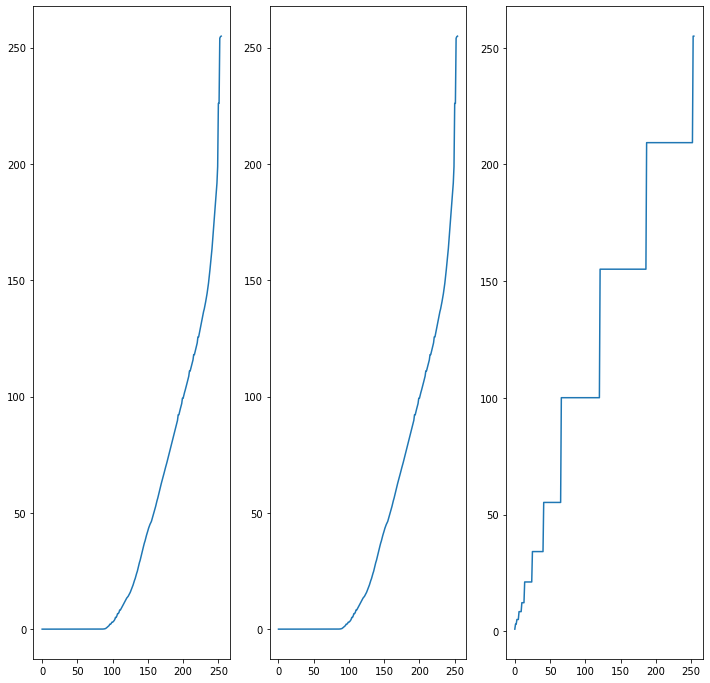

In [13]:
plt.subplot(131)
plt.plot(np.cumsum(hist[0]))
plt.subplot(132)
plt.plot(equalisation_mapping)
plt.subplot(133)
plt.plot(hist_of_equalised.cumsum())
plt.show()

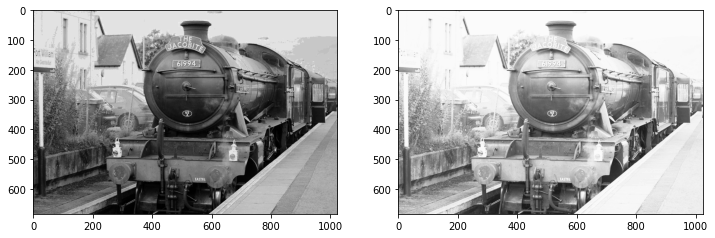

In [14]:
plt.subplot(121)
plt.imshow(img_equalised, cmap='gray')
plt.subplot(122)
plt.imshow(train, cmap='gray')
plt.show()

# Exercise 4 - Implement a hipster filter - 2 Points

1. Convert the image to HSV 
1. Transform the V-Channel with `sigmoid_mapping` and gain = 10.
1. Transform the S-Channel with `sigmoid_mapping` and gain = 10, cufoff=0.35
1. Convert it back to RGB and add the color hsv(0.05, 1, 1) weighted by $0.5\cdot(1 - V)$ to the image, where V is the resulting V-Channel from step 2.

You can test the code with your own image or the `astronaut()` test image.
If you choose a custom image, you can included it through the `urllib` library as done with the lok image.
You can use the `rgb2hsv` and `hsv2rgb` functions from the skimage library.

In [0]:
#apply mapping on only 1 channel

def channel_mapping(image, channel, mapping):
  out = np.copy(image)
  idx = (np.floor(image * (len(mapping)-1))).astype(int)
  out[:,:,channel] = mapping.take(idx[:,:,channel])
  return out


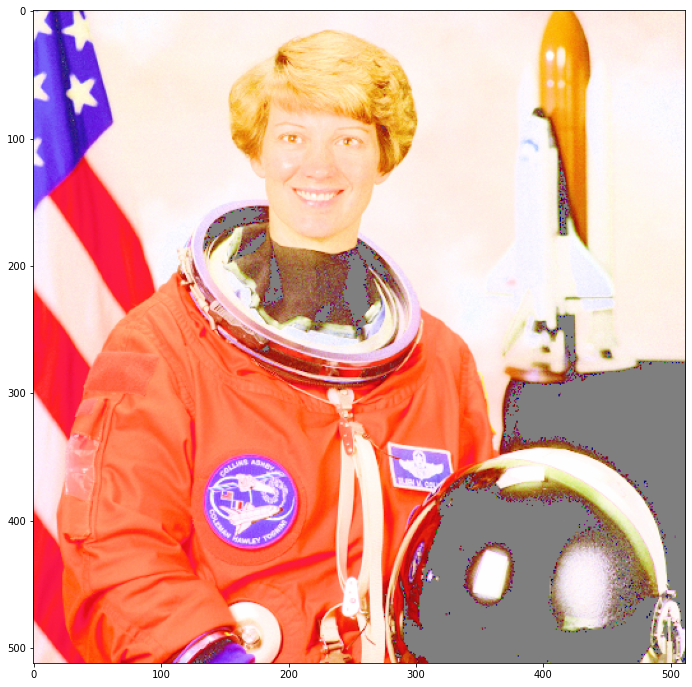

In [16]:
#Transform the V-Channel with sigmoid_mapping and gain = 10.

img2 = channel_mapping(img_hsv, 2, sigmoid_mapping(10, 0))
plt.imshow(hsv2rgb(img2))     # show the result from step 2
plt.show()

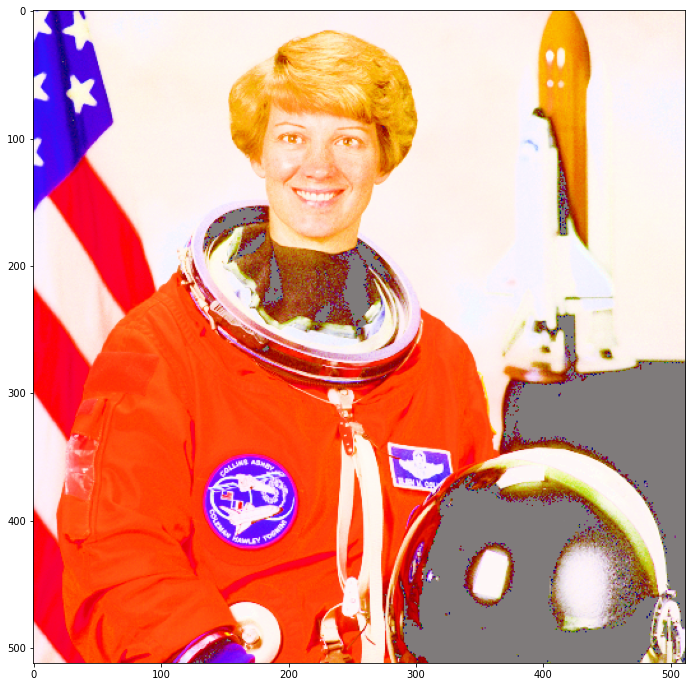

In [17]:
# Transform the S-Channel with sigmoid_mapping and gain = 10, cufoff=0.35

img3 = channel_mapping(img2, 1, sigmoid_mapping(10, 0.35))
plt.imshow(hsv2rgb(img3))     # show the result from step 3
plt.show()


In [0]:
def alter_func(image, array, weight, oimage):
  for z in range(3):
    image[:,:,z] +=  hsv2rgb([[array]])[0,0,z] * weight * (1-oimage[:, :, 2])
  return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


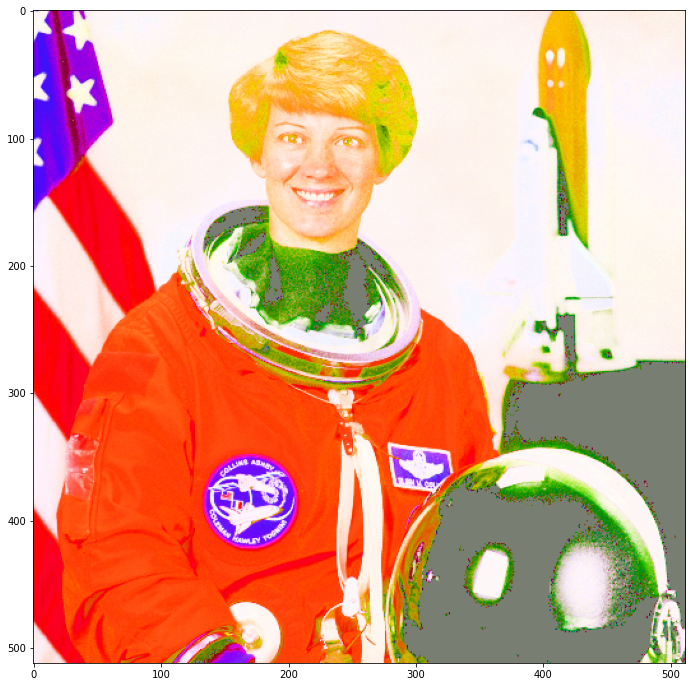

In [19]:
#Convert it back to RGB and add the color hsv(0.05, 1, 1) to the image weight by $0.5\cdot(1 - V)$, where V is the resulting V-Channel from step 2.

img4 = alter_func(img3, [0.05,1,1], 0.5, img2)
plt.imshow(hsv2rgb(img4))     # show the result from step 3
plt.show()

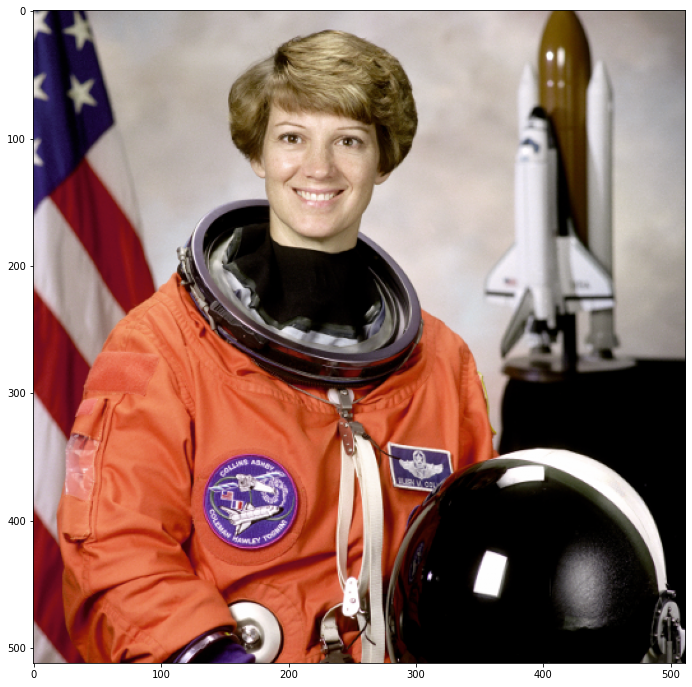

In [20]:
plt.imshow(img)

# Exercise 5 - Implement your own hipster filter - 3 Points

You have mostly complete artistic freedom in this exercise. 
The filter should not be trivial. Converting the image only to grayscale is not enough ;) 
You should show off your knowledge of histogram transformations. (Use at least 2 histogram transformations)

In [0]:
copyimg = img_hsv

In [0]:
#adds colour to channel post threshold

def add_colour(image, thresh, amount):
  image = np.where(image < thresh, image, + amount)
  return image

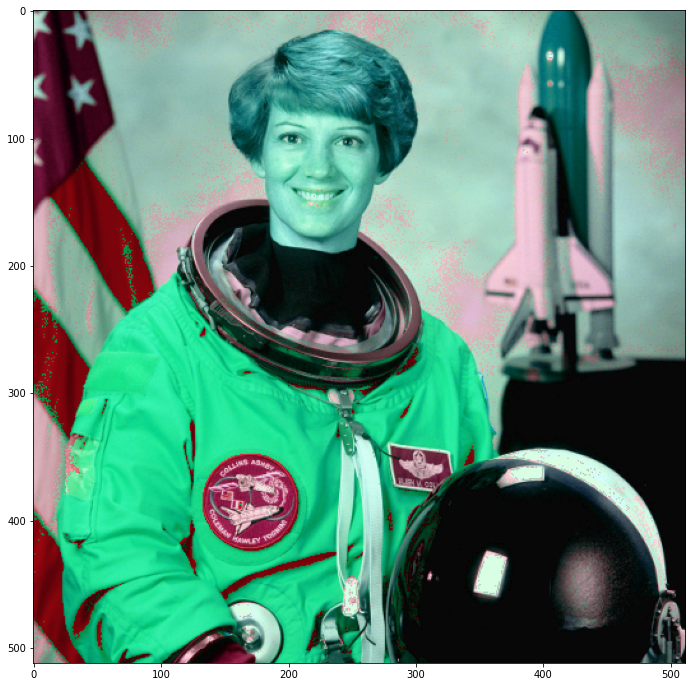

In [23]:
#adds color, 2 sigmoidsmapping on 2 different channels, alterfunc, gammamapping

def hipster_filter(image, image2):
  image = add_colour(copyimg, 1, 0.8)
  image = channel_mapping(image, 1, sigmoid_mapping(5, 0.35))
  image = channel_mapping(image, 0, sigmoid_mapping(5, 0.35))
  image = alter_func(image , [0.5,0.2,0.1], 0.3, image2)
  image = channel_mapping(image, 0, gamma_mapping(0.5))
  return image

plt.imshow(hsv2rgb(hipster_filter(copyimg, img)))
